In [1]:
from example import spark

:: loading settings :: url = jar:file:/Users/da/.pyenv/versions/3.8.10/envs/rikai-example/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/da/.ivy2/cache
The jars for the packages stored in: /Users/da/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-09cb669c-c520-4d87-be50-3c133c7e49f1;1.0
	confs: [default]
	found ai.eto#rikai_2.12;0.0.16 in central
	found org.antlr#antlr4-runtime;4.8-1 in local-m2-cache
	found com.thoughtworks.enableIf#enableif_2.12;1.1.7 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found com.typesafe.scala-logging#scala-logging_2.12;3.9.4 in central
	found org.slf4j#slf4j-api;1.7.30 in spark-list
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.circe#circe-generic_2.12;0.12.3 in central
	found com.chuusai#shapeless_2.12;2.3.3 in spark-list
	found org.typeleve

In [2]:
from rikai.contrib.yolov5.transforms import OUTPUT_SCHEMA

spark.sql(f"""
CREATE MODEL yolov5s
FLAVOR yolov5
PREPROCESSOR 'rikai.contrib.yolov5.transforms.pre_processing'
POSTPROCESSOR 'rikai.contrib.yolov5.transforms.post_processing'
OPTIONS (device="cpu", batch_size=32)
RETURNS {OUTPUT_SCHEMA}
USING "torchhub:///ultralytics/yolov5:v6.0/yolov5s";
""")

2021-12-29 14:37:23,723 INFO Rikai (torchhub_registry.py:62): Resolving model yolov5s from torchhub:///ultralytics/yolov5:v6.0/yolov5s
2021-12-29 14:37:25,638 INFO Rikai (base.py:210): Created model inference pandas_udf with name yolov5s_d5b192e4


DataFrame[]

In [3]:
from rikai.spark.functions import init
init(spark)

21/12/29 14:37:27 WARN SimpleFunctionRegistry: The function area replaced a previously registered function.


In [13]:
from rikai.spark.types.geometry import Box2dType
from rikai.types.geometry import Box2d
from pyspark.sql.types import ArrayType, FloatType
from typing import List
from pyspark.sql.functions import udf

@udf(returnType=ArrayType(Box2dType()))
def array_box2d(arr_coords) -> List[Box2d]:
    """Build a Box2d from array of ``[xmin,ymin,xmax,ymax]`` arrays."""
    result = []
    for coords in arr_coords:
        result.append(Box2d(coords[0], coords[1], coords[2], coords[3]))
    return result

spark.udf.register("array_box2d", array_box2d)

<function __main__.array_box2d(arr_coords) -> List[rikai.types.geometry.Box2d]>

In [14]:
result = spark.sql("""
from (
    from (
        select 
            frame_id,
            date_format(ts, 'mm:ss.SSS') as ts,
            image_data
        from video.`elephants_dream.mp4`
        where frame_id > 1000 and frame_id < 1100
    )
    select
    frame_id,
    ts,
    to_image(image_data) as image,
    ML_PREDICT(yolov5s, image_data) as pred
)
select
    frame_id,
    ts,
    image,
    array_box2d(pred.boxes) as boxes
limit 10
""").collect()

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'file:///Users/da/da-tubi/rikai-example/elephants_dream.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: mp41
    creation_time   : 1970-01-01T00:00:00.000000Z
    title           : Elephants Dream - http://www.archive.org/details/ElephantsDream
    artist          : Bassam Kurdali
    composer        : Bassam Kurdali
    date            : 2006
    encoder         : Lavf51.10.0
    comment         : license:  http://creativecommons.org/licenses/by/3.0/us/
  Duration: 00:10:53.79, start: 0.000000, bitrate: 575 kb/s
  Stream #0:0(und): Video: h264 (Constrained Baseline) (avc1 / 0x31637661), yuv420p, 426x240 [SAR 1:1 DAR 71:40], 507 kb/s, 24 fps, 24 tbr, 24 tbn, 48 tbc (default)
    Metadata:
      creation_time   : 1970-01-01T00:00:00.000000Z
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
  Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 64 kb/s (

In [15]:
result[0]

Row(frame_id=1001, ts='00:41.708', image=Image(<embedded>), boxes=[Box2d(xmin=325.1710510253906, ymin=56.01348876953125, xmax=376.50250244140625, ymax=188.00448608398438)])

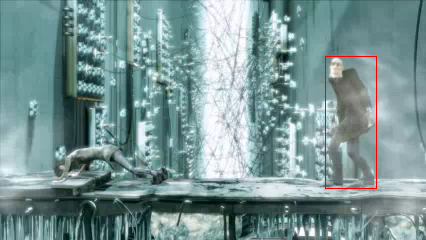

In [19]:
result[0].image | result[0].boxes